# Setting up the spark environment 

In [87]:
import os
exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.2.1
      /_/

Using Python version 3.8.8 (default, Apr 13 2021 12:59:45)
Spark context Web UI available at http://akhileshs-mbp.lan:4041
Spark context available as 'sc' (master = local[*], app id = local-1652155559788).
SparkSession available as 'spark'.


In [89]:
import pyspark
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.appName("Churn Prediction").getOrCreate()
spark.sparkContext.setLogLevel('ERROR')

In [90]:
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1652155559788'),
 ('spark.driver.memory', '12g'),
 ('spark.sql.warehouse.dir',
  'file:/Users/akhilesh/college/Big%20Data/Project/spark-warehouse'),
 ('spark.driver.host', 'akhileshs-mbp.lan'),
 ('spark.app.startTime', '1652155559115'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.driver.port', '58342'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

# Loading the Json file obtained from kafka for offline data analaysis 

In [91]:
def spark_read(spark):
    return spark.read.option('inferSchema', 'true').option('header', 'true').option('encoding', 'utf-8')

In [92]:
def load_full_json_file(spark):
    df = spark_read(spark).json('sparkify_event_data.json')
    return df

In [93]:
df = load_full_json_file(spark)

In [94]:
df.cache()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [95]:
from pyspark import StorageLevel

log4jLogger = spark.sparkContext._jvm.org.apache.log4j

LOGGER = log4jLogger.LogManager.getLogger('driver_logger')

def info(message, print_on_notebook = True):
    LOGGER.info(message)
    
    if print_on_notebook:
        print(message)
        
def set_storage_on_memory(df):
    df.persist(StorageLevel.MEMORY_ONLY)
    info('Storage set to MEMORY_ONLY')

info('Logger instance created')

set_storage_on_memory(df)

Logger instance created
Storage set to MEMORY_ONLY


# Total number of data counts in our current dataset

In [96]:
df.count()

26259199

# Import libraries

In [97]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, stddev,\
split, udf, count, countDistinct, desc, first
from pyspark.sql.functions import max as fmax
from pyspark.sql.functions import min as fmin
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler,\
StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import rand, col, when, concat, array, substring,lit,udf,lower,\
sum as ps_sum,count as ps_count, row_number
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler, BucketedRandomProjectionLSH, VectorSlicer
from pyspark.sql.functions import first
from pyspark.sql.functions import split
from pyspark.sql.functions import date_format
from pyspark.sql.types import FloatType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, \
LinearSVC, GBTClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import DataFrame


from functools import reduce
import random
import time
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Schema 

In [98]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Checking the user and session ID Count 

In [99]:
df.describe("userId").show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|          26259199|
|   mean|1488379.8347142653|
| stddev|286970.08894623973|
|    min|           1000025|
|    max|           1999996|
+-------+------------------+



In [100]:
df.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|          26259199|
|   mean|100577.99253503505|
| stddev| 71909.21077875949|
|    min|                 1|
|    max|            240381|
+-------+------------------+



# Removing the rows that have no user ID

In [101]:
valid_df = df.filter(col("userId") != "")

In [102]:
valid_df.describe("userId").show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|          26259199|
|   mean|1488379.8347142653|
| stddev|286970.08894623973|
|    min|           1000025|
|    max|           1999996|
+-------+------------------+



In [103]:
valid_df.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|          26259199|
|   mean|100577.99253503505|
| stddev| 71909.21077875949|
|    min|                 1|
|    max|            240381|
+-------+------------------+



In [104]:
get_time = udf(lambda x: datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

In [105]:
valid_df = valid_df.withColumn("time", get_time(valid_df.ts))

In [106]:
valid_df.head()

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042', time='2018-09-30 20:00:01')

# The dataset has a pages column that defines where the user is present based on all may happened event pages

1. About
2. Add Friend
3. Add to Playlist
4. Cancel
5. Cancellation Confirmation
6. Downgrade
7. Error
8. Help
9. Home
10. Login
11. Logout
12. NextSong
13. Register
14. Roll Advert
15. Save Settings
16. Settings
17. Submit Downgrade
18. Submit Registration
19. Submit Upgrade
20. Thumbs Down
21. Thumbs Up
22. Upgrade

We may pay specific attention in Cancellation Confirmation, We use this event to flag and create a churn column.

# Removing duplicates 

In [107]:
valid_df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



# Number of cancellation events in the dataset 

In [108]:
valid_df.filter(col("page") == "Cancellation Confirmation").count()

5003

# Creating dataset in respect to churn variable for better data insights on why users have churned, or what factors contribute to users cancelling their subscription on the Sparkify platform

In [109]:
flag_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
valid_churn_df = valid_df.withColumn("Churned", flag_churn("page"))
userwindow = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
valid_churn_df = valid_churn_df.withColumn('Churn', fmax('Churned').over(userwindow))
churned_rate = valid_churn_df.groupby("userId").agg({"Churned": "sum"})\
.select(avg("sum(Churned)").alias("avg_sum_churn")).collect()[0]["avg_sum_churn"]
valid_churn_df.groupBy("userId", "Churn").count().show()

+-------+-----+-----+
| userId|Churn|count|
+-------+-----+-----+
|1000280|    1| 1317|
|1000353|    1|  299|
|1000503|    1|  219|
|1001129|    0|  682|
|1001163|    1|  315|
|1001246|    0|  864|
|1001393|    0|  637|
|1001559|    0| 1290|
|1001607|    0| 2307|
|1001759|    0|   73|
|1001904|    0| 1668|
|1001963|    0|  805|
|1002185|    0| 2080|
|1002295|    0| 1057|
|1002397|    0|  208|
|1002491|    0| 1089|
|1002763|    0|  257|
|1004060|    0| 3396|
|1004316|    0| 1194|
|1004747|    0| 2290|
+-------+-----+-----+
only showing top 20 rows



# User Churn Ratio 

In [110]:
print("churned: {:.2f}%".format(churned_rate * 100))

churned: 22.46%


In [111]:
user_counts = valid_churn_df.groupBy("auth")\
             .agg(countDistinct("userId").alias("user_counts"))\
             .sort(col("user_counts").desc())

In [112]:
user_counts.show()

+----------+-----------+
|      auth|user_counts|
+----------+-----------+
| Logged In|      22277|
| Cancelled|       5003|
|     Guest|          1|
|Logged Out|          1|
+----------+-----------+



# Gender count towards Churn (Data Exploration)

In [113]:
gender_counts = valid_churn_df.groupBy("gender")\
                .agg(countDistinct("userId").alias("user_counts"))\
                .sort(col("user_counts").desc())

In [114]:
gender_counts.show()

+------+-----------+
|gender|user_counts|
+------+-----------+
|     M|      11651|
|     F|      10626|
|  null|          1|
+------+-----------+



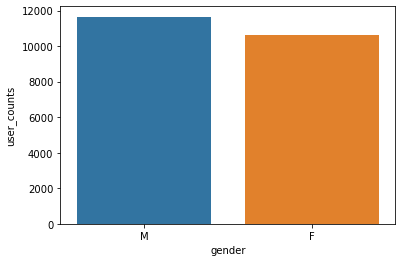

In [115]:
sns.barplot(x='gender', y='user_counts', data=gender_counts.toPandas());

# We can see there are more male users than female users in our dataset 

# Unique user sessions (Data Exploration)

In [116]:
iteminsession_counts = valid_churn_df.select(countDistinct(col("itemInSession")).alias("item_counts"))
iteminsession_counts.show()

+-----------+
|item_counts|
+-----------+
|       1429|
+-----------+



# Unique user sessions (Length)

In [117]:
length_df = valid_churn_df.select(col("length")).dropna()
length_df.show()

+----------+
|    length|
+----------+
| 524.32934|
| 238.39302|
| 140.35546|
| 277.15873|
|1121.25342|
| 229.25016|
|  313.5473|
|  250.8273|
| 203.88526|
| 183.87546|
|  265.9522|
| 199.81016|
| 131.91791|
| 248.78975|
| 126.40608|
| 355.57832|
|  204.7473|
| 293.85098|
| 267.12771|
| 256.80934|
+----------+
only showing top 20 rows



/Users/akhilesh/college/anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


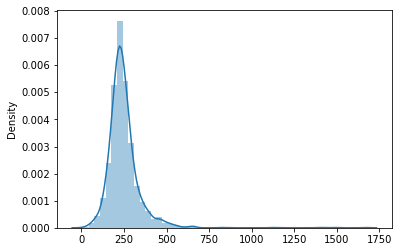

In [118]:
sns.distplot(length_df.limit(2000).toPandas());

# Length looks like a gaussian distribution with long write tail. Most of length values are concentrated between 0 and 500.

# User Level (Free Vs Paid)

In [119]:
level_counts = valid_churn_df.groupBy("level")\
                .agg(countDistinct("userId").alias("user_counts"))\
                .sort(col("user_counts").desc())
level_counts.show()

+-----+-----------+
|level|user_counts|
+-----+-----------+
| free|      18793|
| paid|      16185|
+-----+-----------+



# User Interaction (Free Vs Paid)

In [120]:
valid_churn_df.filter(valid_churn_df["level"] == "paid") \
      .select("userId").dropDuplicates() \
      .intersect(valid_churn_df.filter(valid_churn_df["level"] == "free") \
      .select("userId").dropDuplicates() \
      ).count()

12700

# Location Analysis (Data Exploration)

In [121]:
location_counts = valid_churn_df.groupBy("location")\
                .agg(countDistinct("userId").alias("user_counts"))\
                .sort(col("user_counts").desc())

In [122]:
location_counts_pd = location_counts.toPandas()
location_counts_pd.head()

,location,user_counts
0,"New York-Newark-Jersey City, NY-NJ-PA",1570
1,"Los Angeles-Long Beach-Anaheim, CA",1025
2,"Chicago-Naperville-Elgin, IL-IN-WI",682
3,"Dallas-Fort Worth-Arlington, TX",495
4,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",485


In [123]:
location_counts_pd = location_counts_pd.join(location_counts_pd['location'].str.split(',',expand=True)\
                                        .rename(columns={0:'city', 1:'state'})).drop('location',axis=1)
location_counts_pd.head()


,user_counts,city,state
0,1570,New York-Newark-Jersey City,NY-NJ-PA
1,1025,Los Angeles-Long Beach-Anaheim,CA
2,682,Chicago-Naperville-Elgin,IL-IN-WI
3,495,Dallas-Fort Worth-Arlington,TX
4,485,Philadelphia-Camden-Wilmington,PA-NJ-DE-MD


# Location Analysis (State)

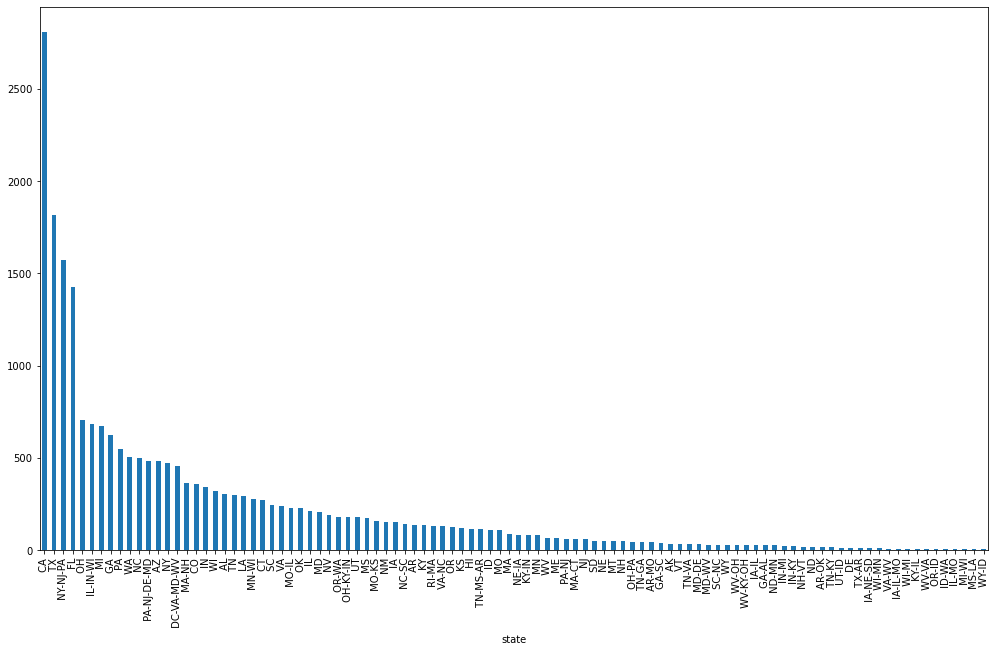

In [124]:
location_counts_pd.groupby('state')['user_counts'].sum().sort_values(ascending=False)\
.plot(kind='bar', figsize=(17,10))
plt.show()

# California has the most wide user base, followed by texas and new york state 

# Location Analysis (City)

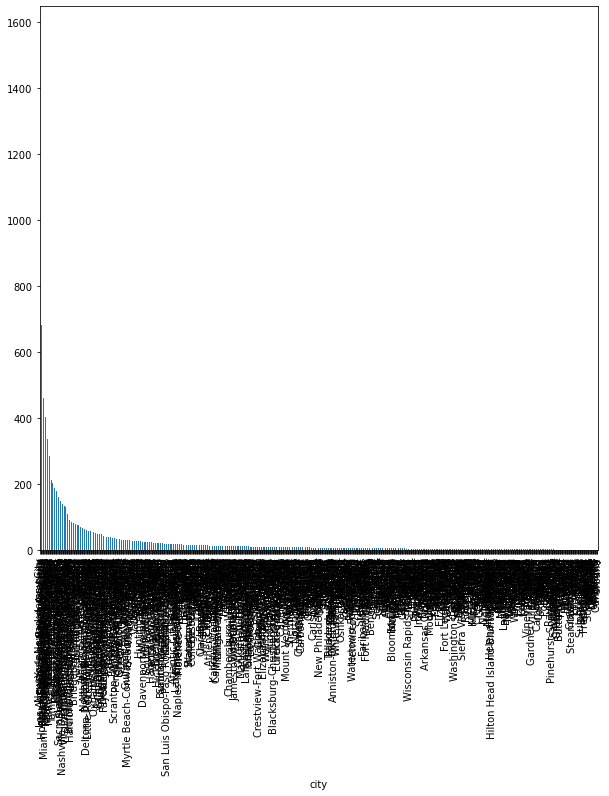

In [125]:
location_counts_pd.groupby('city')['user_counts'].sum().sort_values(ascending=False)\
.plot(kind='bar', figsize=(10,10))
plt.show()

# Page Count Analysis 

In [126]:
page_counts = valid_churn_df.groupBy("page")\
                .agg(countDistinct("userId").alias("user_counts"))\
                .sort(col("user_counts").desc())
page_counts.show()


+--------------------+-----------+
|                page|user_counts|
+--------------------+-----------+
|            NextSong|      22261|
|                Home|      22073|
|           Thumbs Up|      21732|
|     Add to Playlist|      21260|
|              Logout|      21160|
|          Add Friend|      20305|
|         Roll Advert|      20068|
|         Thumbs Down|      20031|
|            Settings|      18933|
|                Help|      18244|
|             Upgrade|      16151|
|           Downgrade|      15209|
|               About|      14461|
|       Save Settings|      12237|
|      Submit Upgrade|      12082|
|               Error|      11273|
|    Submit Downgrade|       5103|
|              Cancel|       5003|
|Cancellation Conf...|       5003|
|            Register|          1|
+--------------------+-----------+
only showing top 20 rows



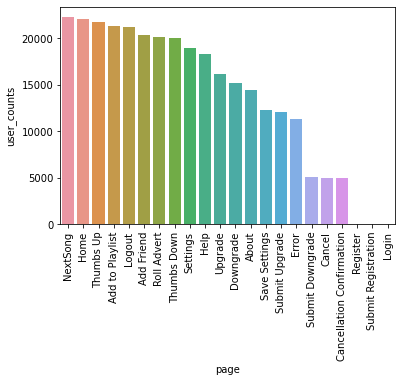

In [127]:
sns.barplot(x="page", y="user_counts", data=page_counts.toPandas())
plt.xticks(rotation='vertical')
plt.show()

# Most of users are in NextSong, Home, Thumbs Up or Add to Playlist When we have few that cancel, or in Cancellation Confirmation or Submit Downgrade

# User Device Analysis (Data Exploration)

In [128]:
useragent_counts = valid_churn_df.groupBy("userAgent")\
                .agg(countDistinct("userId").alias("user_counts"))\
                .sort(col("user_counts").desc())
useragent_counts.show()


+--------------------+-----------+
|           userAgent|user_counts|
+--------------------+-----------+
|"Mozilla/5.0 (Win...|       2024|
|Mozilla/5.0 (Wind...|       1661|
|"Mozilla/5.0 (Win...|       1395|
|"Mozilla/5.0 (Mac...|       1340|
|"Mozilla/5.0 (Mac...|       1229|
|"Mozilla/5.0 (Mac...|       1084|
|Mozilla/5.0 (Maci...|       1000|
|"Mozilla/5.0 (Mac...|        998|
|"Mozilla/5.0 (Mac...|        913|
|"Mozilla/5.0 (Win...|        795|
|Mozilla/5.0 (Wind...|        529|
|"Mozilla/5.0 (iPh...|        517|
|"Mozilla/5.0 (Win...|        510|
|Mozilla/5.0 (Wind...|        487|
|"Mozilla/5.0 (Win...|        410|
|Mozilla/5.0 (X11;...|        361|
|Mozilla/5.0 (Wind...|        317|
|"Mozilla/5.0 (Win...|        281|
|"Mozilla/5.0 (iPa...|        259|
|Mozilla/5.0 (Wind...|        239|
+--------------------+-----------+
only showing top 20 rows



# Classify devices used by each user while being present on the platform  

In [129]:
def get_browser(x):
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return 'Other'

In [130]:
useragent_counts_pd = useragent_counts.toPandas()
useragent_counts = useragent_counts.dropna()
get_browser_udf = udf(get_browser)
useragent_counts1 = useragent_counts.withColumn("browser",  get_browser_udf("userAgent"))

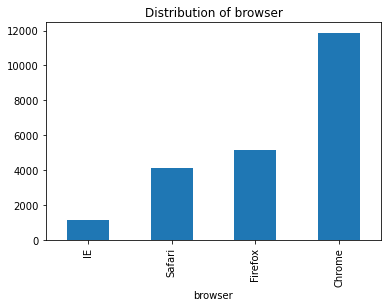

In [131]:
plt.title("Distribution of browser")
useragent_counts1.toPandas().groupby('browser')['user_counts'].sum().sort_values().plot(kind='bar')
plt.show()

# We see that Chrome browser is far most used, it's followed by firefox and safari. IE is very little bit used.

# User Analysis (Day & Time)

In [50]:
time_dt = valid_churn_df.select("time", "userId")
time_dt.show()

+-------------------+-------+
|               time| userId|
+-------------------+-------+
|2018-09-30 20:00:01|1749042|
|2018-09-30 20:00:02|1563081|
|2018-09-30 20:00:02|1697168|
|2018-09-30 20:00:03|1222580|
|2018-09-30 20:00:03|1714398|
|2018-09-30 20:00:04|1010522|
|2018-09-30 20:00:05|1475659|
|2018-09-30 20:00:06|1465194|
|2018-09-30 20:00:06|1558463|
|2018-09-30 20:00:06|1605667|
|2018-09-30 20:00:06|1385500|
|2018-09-30 20:00:06|1032628|
|2018-09-30 20:00:07|1901081|
|2018-09-30 20:00:07|1611729|
|2018-09-30 20:00:08|1497881|
|2018-09-30 20:00:08|1413952|
|2018-09-30 20:00:08|1585800|
|2018-09-30 20:00:08|1261737|
|2018-09-30 20:00:08|1009070|
|2018-09-30 20:00:10|1041334|
+-------------------+-------+
only showing top 20 rows



In [51]:
from pyspark.sql.functions import rand 
time_dt = time_dt.orderBy(rand())

In [52]:
time_dt_pd = time_dt.limit(100000).toPandas()
time_dt_pd['time'] = pd.to_datetime(time_dt_pd['time'])
time_dt_pd.head()

,time,userId
0,2018-10-08 09:45:35,1611418
1,2018-11-08 14:24:51,1291962
2,2018-11-28 16:41:36,1966004
3,2018-11-10 08:46:14,1056495
4,2018-10-27 07:29:01,1149569


<AxesSubplot:xlabel='weekday'>

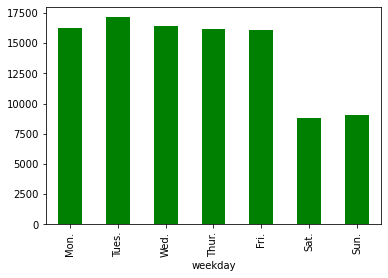

In [53]:
weekday_dict = {0:'Mon.',1:'Tues.',2:'Wed.',3:'Thur.',4:'Fri.',5:'Sat.',6:'Sun.'}
time_dt_pd['weekday'] = time_dt_pd['time'].dt.weekday.map(weekday_dict)
time_dt_pd['day'] = time_dt_pd['time'].dt.day
time_dt_pd['hour'] = time_dt_pd['time'].dt.hour
time_dt_pd.groupby('weekday')['userId'].count().loc[list(weekday_dict.values())].plot(kind='bar',color='#008000')

<AxesSubplot:xlabel='day'>

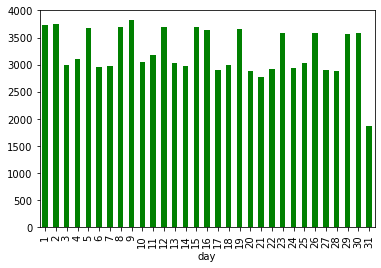

In [54]:
time_dt_pd.groupby('day')['userId'].count().plot(kind='bar',color='#008000')

<AxesSubplot:xlabel='hour'>

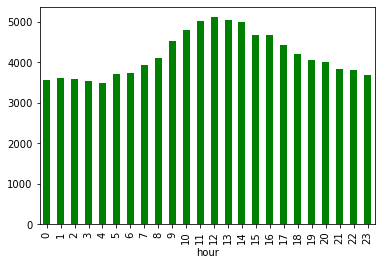

In [55]:
time_dt_pd.groupby('hour')['userId'].count().plot(kind='bar',color="#008000")

# Users' behaviors are periodic, they use Sparkify more often in workdays than weekend; In one single day, they use Sparkify more often after 14 o'clock.

# Effect of each feature on churn (Analysis)

In [58]:
label_churn = udf(lambda x: "Churn" if x == 1 else "Not churn")
user_churn = valid_churn_df.groupby("userId").max("Churn").withColumnRenamed("max(Churn)", "Churned")

In [59]:
def churned(df):
    """Create new Churned on pyspark df
    Input 
     df spark: dataframe
     
    Output 
     spark df 
    """
    results = df.withColumn("Churned", label_churn("Churn"))
    return results

In [60]:
valid_churn_df = churned(valid_churn_df)

In [61]:
valid_churn_df.select("auth", "Churned").show()

+---------+-------+
|     auth|Churned|
+---------+-------+
|Logged In|  Churn|
|Logged In|  Churn|
|Logged In|  Churn|
|Logged In|  Churn|
|Logged In|  Churn|
|Logged In|  Churn|
|Logged In|  Churn|
|Logged In|  Churn|
|Logged In|  Churn|
|Logged In|  Churn|
|Logged In|  Churn|
|Logged In|  Churn|
|Logged In|  Churn|
|Logged In|  Churn|
|Logged In|  Churn|
|Logged In|  Churn|
|Logged In|  Churn|
|Logged In|  Churn|
|Logged In|  Churn|
|Logged In|  Churn|
+---------+-------+
only showing top 20 rows



In [62]:
valid_churn_df.dropDuplicates(["userId"]).groupby(["Churned", "auth"]).count().sort("Churned").show()

+---------+----------+-----+
|  Churned|      auth|count|
+---------+----------+-----+
|    Churn| Logged In| 5003|
|Not churn| Logged In|17274|
|Not churn|Logged Out|    1|
+---------+----------+-----+



In [63]:
valid_churn_df.dropDuplicates(["userId", "gender"]).groupby(["Churned", "gender"]).count().sort("Churned").show()

+---------+------+-----+
|  Churned|gender|count|
+---------+------+-----+
|    Churn|     F| 2347|
|    Churn|     M| 2656|
|Not churn|  null|    1|
|Not churn|     M| 8995|
|Not churn|     F| 8279|
+---------+------+-----+



In [64]:
valid_churn_df.select(["Churned", "length"]).groupby(["Churned"]).agg(avg('length').alias('mean_length'), 
                                                                     stddev('length').alias('stdev_length'),
                                                                     fmax('length').alias('max_length'),
                                                                     fmin('length').alias('min_length')).show()

+---------+------------------+-----------------+----------+----------+
|  Churned|       mean_length|     stdev_length|max_length|min_length|
+---------+------------------+-----------------+----------+----------+
|    Churn|  248.680031572098|97.31322630186042|3024.66567|     0.522|
|Not churn|248.73752863664356|97.28014262879445|3024.66567|     0.522|
+---------+------------------+-----------------+----------+----------+



In [65]:
valid_churn_df.dropDuplicates(["userId"]).groupby(["Churned", "level"]).count().sort("Churned").show()

+---------+-----+-----+
|  Churned|level|count|
+---------+-----+-----+
|    Churn| paid| 1239|
|    Churn| free| 3764|
|Not churn| free|13484|
|Not churn| paid| 3791|
+---------+-----+-----+



### Location

In [66]:
def normalize_data(groupby_data):
    groupby_series = groupby_data.set_index(list(groupby_data.columns[:2]))
    temp = groupby_series.unstack('Churned').fillna(0)
    df = pd.DataFrame(((temp - temp.min()) / (temp.max() - temp.min())).stack()).reset_index()
    df = df.rename(columns={df.columns[-1]: 'results'})
    return df

In [67]:
split_city_state = split(valid_churn_df['location'], ',')
valid_churn_df = valid_churn_df.withColumn('state', split_city_state.getItem(1))
state_data = valid_churn_df.dropDuplicates(["userId"]).groupby(["state","Churned"])\
            .count().sort("state").toPandas()
normalize_state_data = normalize_data(state_data)
normalize_state_data.head()


,state,Churned,results
0,NaN,Churn,0.000000
1,NaN,Not churn,0.000000
2,AK,Churn,0.013180
3,AK,Not churn,0.011384
4,AL,Churn,0.108731


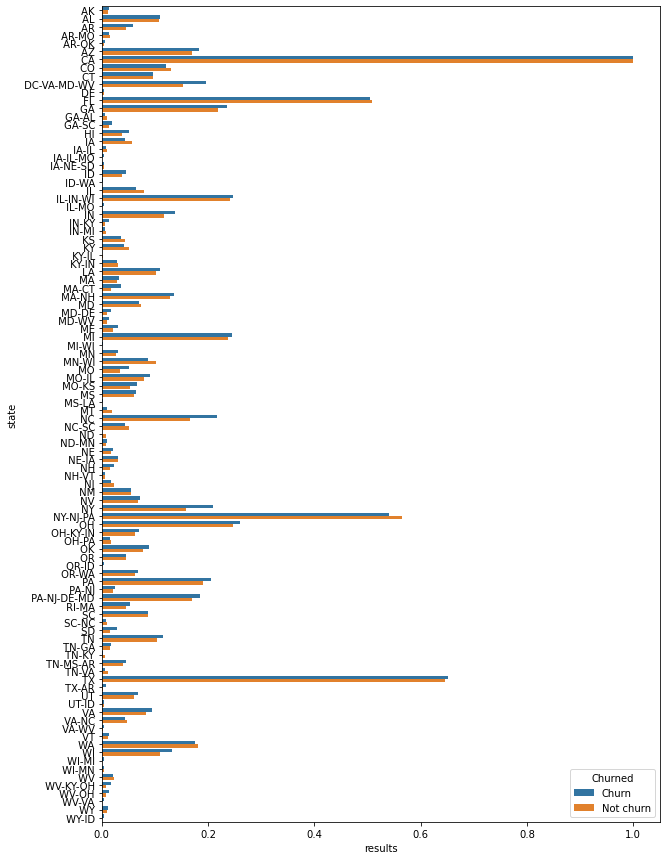

In [68]:
fig, ax = plt.subplots(figsize=(10,15))
sns.barplot( x="results", y="state", hue="Churned",
            data=normalize_state_data, ax=ax)
plt.show()

### Page

In [69]:
valid_churn_df.select(["Churned", "page"]).groupby(["Churned", "page"]).count().sort("page").show()

+---------+--------------------+--------+
|  Churned|                page|   count|
+---------+--------------------+--------+
|Not churn|               About|   82657|
|    Churn|               About|   10102|
|Not churn|          Add Friend|  301654|
|    Churn|          Add Friend|   80010|
|    Churn|     Add to Playlist|  124656|
|Not churn|     Add to Playlist|  473265|
|    Churn|              Cancel|    5003|
|    Churn|Cancellation Conf...|    5003|
|    Churn|           Downgrade|   43424|
|Not churn|           Downgrade|  140816|
|    Churn|               Error|    5330|
|Not churn|               Error|   20632|
|Not churn|                Help|  127598|
|    Churn|                Help|   27502|
|Not churn|                Home| 1145400|
|    Churn|                Home|  197702|
|Not churn|               Login|  296350|
|Not churn|              Logout|  233305|
|    Churn|              Logout|   62700|
|Not churn|            NextSong|16463996|
+---------+--------------------+--

In [70]:
page_data = valid_churn_df.select(["Churned", "page"]).groupby(["Churned", "page"]).count().sort("page").toPandas()
page_data = normalize_data(page_data)


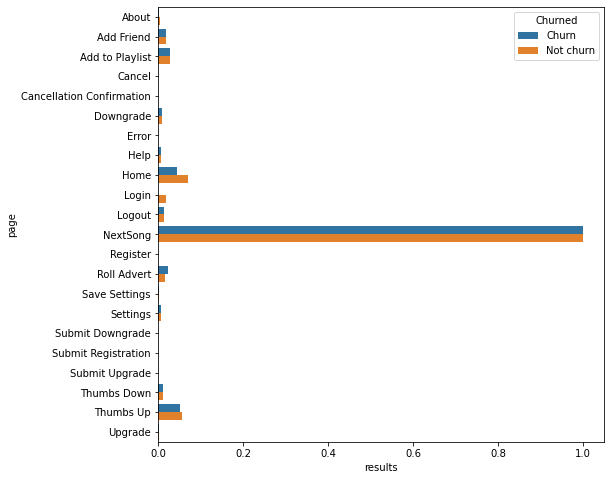

In [71]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x="results", y="page", hue="Churned",
            data=page_data,ax=ax)
plt.show()

# NextSong,Thumbs Up/Down, Home, Add to Playlist page's seems to have effect on Churn or not.